In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

np.random.seed(42)

In [2]:
aapl = yf.Ticker('AAPL')
time = '3y'

data = aapl.history(period = time)

data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,751.000000,751.000000,751.000000,751.000000,7.510000e+02,751.000000,751.0
mean,196.448044,198.480859,194.648297,196.673588,5.831475e+07,0.003955,0.0
std,32.958784,33.228811,32.663161,32.999353,2.472740e+07,0.031077,0.0
min,124.137232,125.871071,122.324571,123.161942,2.323470e+07,0.000000,0.0
25%,172.244246,174.263562,171.204216,172.333725,4.443860e+07,0.000000,0.0
50%,192.343591,193.918648,190.606265,192.167313,5.223810e+07,0.000000,0.0
75%,223.823977,226.007934,221.896191,224.566170,6.552400e+07,0.000000,0.0
max,276.721738,277.051436,269.799988,275.250000,3.186799e+08,0.260000,0.0


In [3]:
data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-11-14 00:00:00-05:00,146.755996,148.046524,145.238875,146.076248,73374100
2022-11-15 00:00:00-05:00,149.957698,151.307332,146.352089,147.810089,89868300
2022-11-16 00:00:00-05:00,146.913663,147.642656,145.100998,146.578705,64218300
2022-11-17 00:00:00-05:00,144.253745,149.228695,143.977908,148.479996,80389400
2022-11-18 00:00:00-05:00,150.046379,150.430583,147.741160,149.041534,74829600


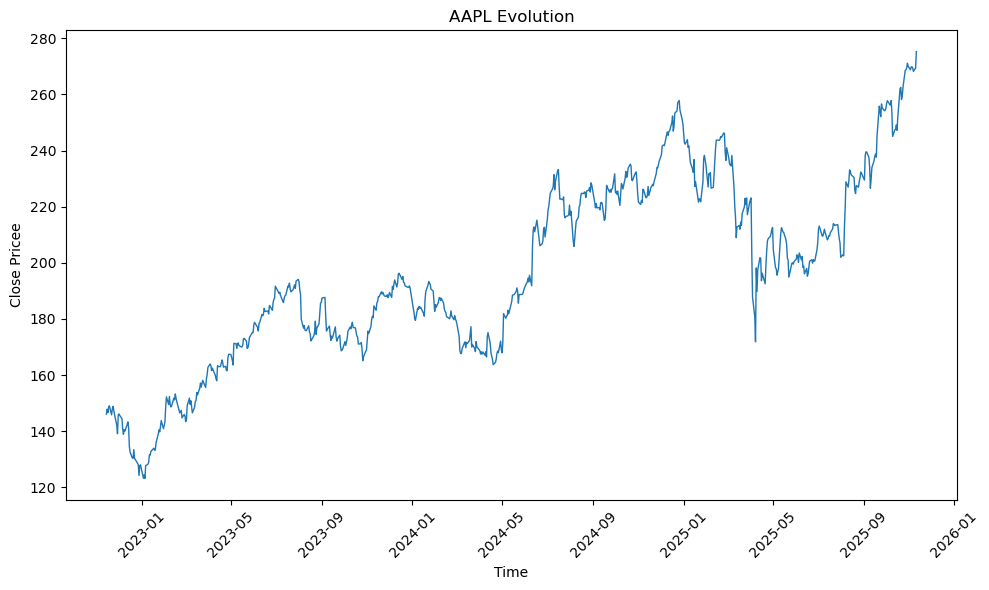

In [4]:
fig, ax = plt.subplots(1,1, figsize = (10,6), dpi = 100)

plt.plot(data.index, data['Close'], linewidth = 1, label = 'Time evolution AAPL')

plt.xticks(rotation = 45)
plt.xlabel('Time')
plt.ylabel('Close Pricee')
plt.title('AAPL Evolution')
plt.tight_layout()
plt.savefig('../figures/stock_figs/aapl.png', dpi = 100)
plt.show()

# Simple Monte Carlo Simulation

In [5]:
num_sim = 20
forecast_days = 200

simulations = np.zeros((num_sim, forecast_days))

last_price = data['Close'].iloc[-1]

daily_returns = data['Close'].pct_change().dropna()

In [6]:
for i in range(num_sim):
    cum_ret = np.random.choice(daily_returns, size = forecast_days, replace = True).cumsum()
    simulations[i, : ] = last_price*(1+cum_ret) # converts the percentage change back to the real price 

    #print(simulations)

In [7]:
print(simulations[2, 0:4])

[272.95514006 274.82199432 277.05546646 276.90324513]


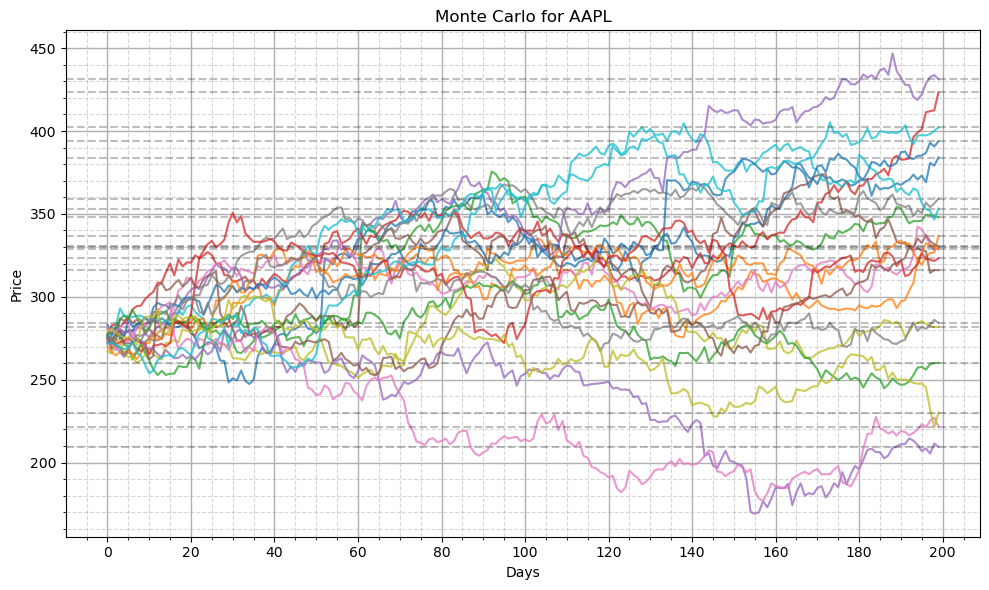

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(num_sim):
    ax.plot(simulations[i, :], alpha=0.75)
    ax.axhline(simulations[i, -1], linestyle='--', color='black', alpha=0.25)

ax.set_title('Monte Carlo for AAPL')
ax.set_xlabel('Days')
ax.set_ylabel('Price')

ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(10))

ax.grid(which="major", linewidth=1)
ax.grid(which="minor", linestyle="--", alpha=0.5)

fig.tight_layout()

plt.savefig('../figures/stock_figs/mc_sim.png', dpi = 100)
plt.show()


# Linear Regression

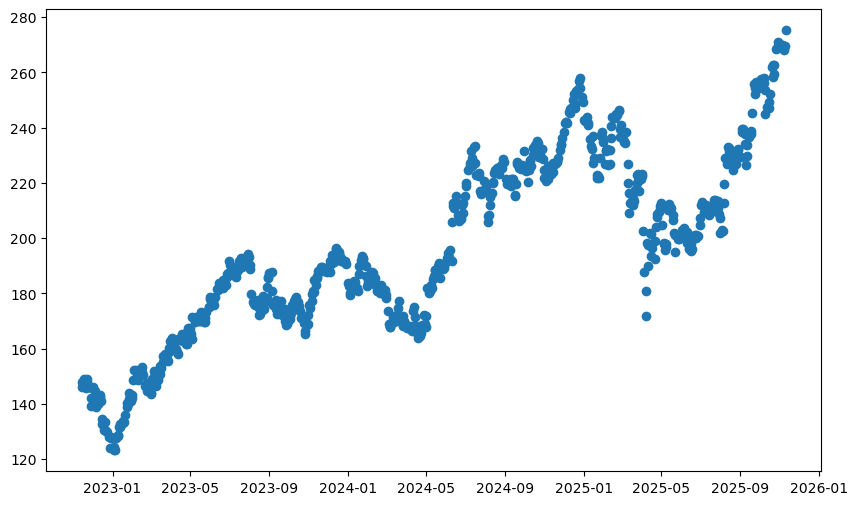

In [9]:
fig, ax = plt.subplots(1,1, figsize = (10,6), dpi = 100)

ax.scatter(data.index, data['Close'])

plt.show()

In [10]:
prices = data['Close']

print(prices.head())
print(type(prices))

Date
2022-11-14 00:00:00-05:00    146.076248
2022-11-15 00:00:00-05:00    147.810089
2022-11-16 00:00:00-05:00    146.578705
2022-11-17 00:00:00-05:00    148.479996
2022-11-18 00:00:00-05:00    149.041534
Name: Close, dtype: float64
<class 'pandas.core.series.Series'>


In [11]:
X = np.arange(len(prices)).reshape(-1,1)
y = prices.values

model = LinearRegression()
model.fit(X,y)

print("Slope (coefficient):", model.coef_[0])
print("Intercept:", model.intercept_)


Slope (coefficient): 0.13023987327619135
Intercept: 147.83363563034942


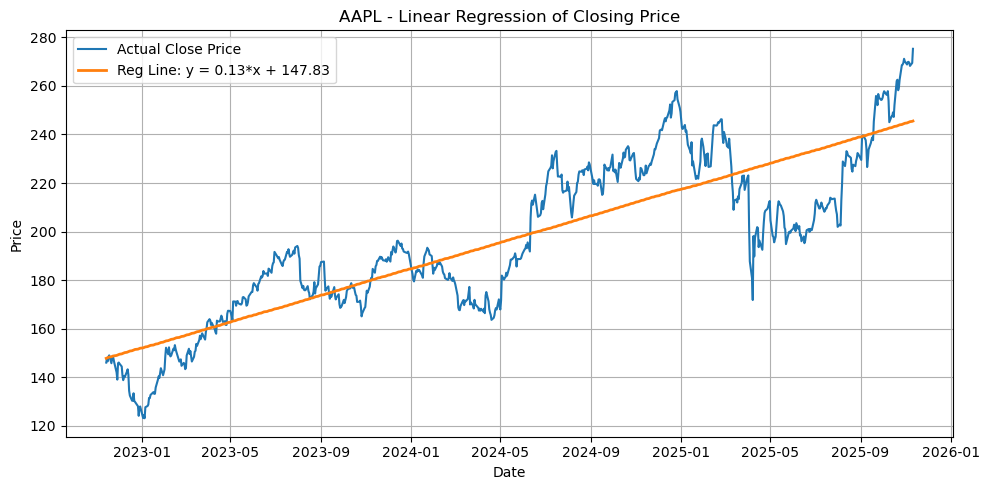

In [12]:
y_pred = model.predict(X)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

dates = prices.index

plt.plot(dates, y, label='Actual Close Price')
plt.plot(dates, y_pred, linewidth=2, label = f'Reg Line: y = {model.coef_[0]:.2f}*x + {model.intercept_:.2f}')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL - Linear Regression of Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Multiple Linear Regression

In [13]:
data['Moving_Average'] = data['Close'].rolling(window = 5).mean()
data.dropna(inplace = True)

data.head()

,Open,High,Low,Close,Volume,Moving_Average
Date,,,,,,
2022-11-18 00:00:00-05:00,150.046379,150.430583,147.741160,149.041534,74829600,147.597314
2022-11-21 00:00:00-05:00,147.928297,148.135168,145.524558,145.810242,58724100,147.544113
2022-11-22 00:00:00-05:00,145.928477,148.184437,144.746300,147.947998,51804100,147.571695
2022-11-23 00:00:00-05:00,147.228880,149.573513,147.120514,148.824814,58301400,148.020917
2022-11-25 00:00:00-05:00,146.105808,146.667343,144.933491,145.908783,35195900,147.506674


In [14]:
small_data = data[['Close', 'Volume', 'Moving_Average']]

print(small_data.head())

                                Close    Volume  Moving_Average
Date                                                           
2022-11-18 00:00:00-05:00  149.041534  74829600      147.597314
2022-11-21 00:00:00-05:00  145.810242  58724100      147.544113
2022-11-22 00:00:00-05:00  147.947998  51804100      147.571695
2022-11-23 00:00:00-05:00  148.824814  58301400      148.020917
2022-11-25 00:00:00-05:00  145.908783  35195900      147.506674


In [15]:
"""

time_steps = np.arange(len(small_data))

X = np.column_stack((time_steps, small_data['Volume'], small_data['Moving_Average']))
y = small_data['Close'].values

split_index = int(0.8 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

"""

time_steps = np.arange(len(small_data))
X = np.column_stack((time_steps, small_data['Volume'], small_data['Moving_Average']))
y = small_data['Close'].values

model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)

fold = 1
for train_index, test_index in tscv.split(X):
    # Split chronologically
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    
    print(f"Fold {fold}:")
    print(f"Train range: {train_index[0]} → {train_index[-1]}")
    print(f"Test range:  {test_index[0]} → {test_index[-1]}")
    print(f"R² = {r2:.3f} | RMSE = {rmse:.3f}")

    print("-" * 40)
    
    fold += 1

Fold 1:
Train range: 0 → 126
Test range:  127 → 250
R² = 0.654 | RMSE = 17.746
----------------------------------------
Fold 2:
Train range: 0 → 250
Test range:  251 → 374
R² = 0.904 | RMSE = 8.244
----------------------------------------
Fold 3:
Train range: 0 → 374
Test range:  375 → 498
R² = 0.914 | RMSE = 12.751
----------------------------------------
Fold 4:
Train range: 0 → 498
Test range:  499 → 622
R² = 0.888 | RMSE = 37.368
----------------------------------------
Fold 5:
Train range: 0 → 622
Test range:  623 → 746
R² = 0.971 | RMSE = 16.781
----------------------------------------


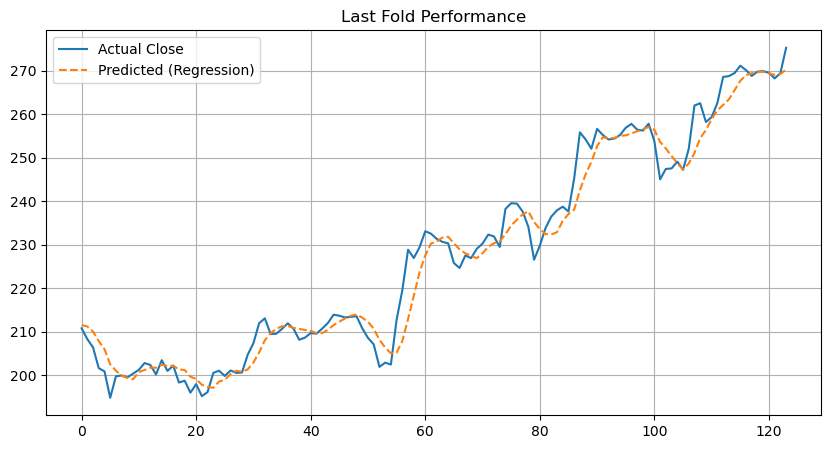

In [16]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual Close')
plt.plot(y_pred, label='Predicted (Regression)', linestyle='--')
plt.title('Last Fold Performance')
plt.legend()
plt.grid(True)
plt.show()